# TS2Vec
Example from [github](https://github.com/zhihanyue/ts2vec)

In [1]:
from ts2vec.ts2vec import TS2Vec
import ts2vec.datautils as datautils

In [2]:
# Load the ECG200 dataset from UCR archive
# (Both train_data and test_data have a shape of n_instances x n_timestamps x n_features)

train_data, train_labels, test_data, test_labels = datautils.load_UCR('ECG200', "./ts2vec")

In [30]:
train_data.shape

(100, 96, 1)

In [29]:
test_data.shape

(100, 96, 1)

In [35]:
train_data[0][:10]

array([[0.50205548],
       [0.54216265],
       [0.72238348],
       [1.4288852 ],
       [2.1365158 ],
       [2.281149  ],
       [1.9362737 ],
       [1.46889   ],
       [1.0088451 ],
       [0.38028224]])

In [37]:
test_data[0][:10]

array([[ 0.42518938],
       [ 1.4185988 ],
       [ 2.6687913 ],
       [ 3.298629  ],
       [ 2.2645539 ],
       [ 0.16517949],
       [-0.95972652],
       [ 0.28266835],
       [ 0.84285041],
       [ 0.68345828]])

In [3]:
# Train a TS2Vec model
model = TS2Vec(
    input_dims=1,
    device=0,
    output_dims=320
)

In [4]:
loss_log = model.fit(
    train_data,
    verbose=True
)

Epoch #0: loss=14.815414508183798
Epoch #1: loss=3.8030190467834473
Epoch #2: loss=3.0187440713246665
Epoch #3: loss=2.798018495241801
Epoch #4: loss=2.6645025412241616
Epoch #5: loss=2.7089697122573853
Epoch #6: loss=2.485351244608561
Epoch #7: loss=2.463841120402018
Epoch #8: loss=2.6049275398254395
Epoch #9: loss=2.5744020541508994
Epoch #10: loss=2.4533983071645102
Epoch #11: loss=2.406620224316915
Epoch #12: loss=2.361240784327189
Epoch #13: loss=2.37575093905131
Epoch #14: loss=2.377883791923523
Epoch #15: loss=2.2845500310262046
Epoch #16: loss=2.3278488715489707
Epoch #17: loss=2.3200170596440635
Epoch #18: loss=2.241689125696818
Epoch #19: loss=2.064570983250936
Epoch #20: loss=2.15480629603068
Epoch #21: loss=2.33440625667572
Epoch #22: loss=2.118372639020284
Epoch #23: loss=2.0634747743606567
Epoch #24: loss=2.0534178217252097
Epoch #25: loss=2.0189768274625144
Epoch #26: loss=2.1272414127985635
Epoch #27: loss=1.9190993309020996
Epoch #28: loss=1.9708504875500996
Epoch #29:

In [5]:
# Compute timestamp-level representations for test set
test_repr = model.encode(test_data)  # n_instances x n_timestamps x output_dims

In [6]:
# Compute instance-level representations for test set
test_repr = model.encode(test_data, encoding_window='full_series')  # n_instances x output_dims

In [7]:
# Sliding inference for test set
test_repr = model.encode(
    test_data,
    causal=True,
    sliding_length=1,
    sliding_padding=50
)  # n_instances x n_timestamps x output_dims
# (The timestamp t's representation vector is computed using the observations located in [t-50, t])

In [8]:
test_repr.shape

(100, 96, 320)

In [9]:
embs = test_repr.mean(axis = 2)

In [10]:
embs.shape

(100, 96)

In [11]:
import numpy as np
import hdbscan

In [12]:
umap_params = {
    'n_neighbors' : 10,
    'min_dist' : 0.01,
    'random_state': 1234
}

In [13]:
from dvats.all import *


Octave is ready <oct2py.core.Oct2Py object at 0x7fe3c1441720>

















In [14]:
prjs = get_UMAP_prjs(embs, cpu=False, **umap_params)

GPU | Used mem: 3
GPU | Used mem: 24
GPU | Memory Usage: [██------------------] 12%
-- cuml.UMAP -- False
GPU | Used mem: 2
GPU | Used mem: 24
GPU | Memory Usage: [█-------------------] 8%


In [24]:
import matplotlib.pyplot as plt  # requires: pip install matplotlib
import numpy as np
import pandas as pd

In [16]:
# Define HDBSCAN parameters
hdbscan_kwargs = {
    'min_cluster_size' : 5,
    'min_samples' : 7,
    'cluster_selection_epsilon' : 0.0001,
}
metric_kwargs = {
    'metric' : 'euclidean' #'jaccard' 
}

In [17]:
clusters = hdbscan.HDBSCAN(**hdbscan_kwargs, **metric_kwargs).fit(prjs)
clusters_labels = clusters.labels_

In [25]:
#| export
def plot_projections(prjs, umap_params, fig_size = (25,25)):
    "Plot 2D projections thorugh a connected scatter plot"
    df_prjs = pd.DataFrame(prjs, columns = ['x1', 'x2'])
    fig = plt.figure(figsize=(fig_size[0],fig_size[1]))
    ax = fig.add_subplot(111)
    ax.scatter(df_prjs['x1'], df_prjs['x2'], marker='o', facecolors='none', edgecolors='b', alpha=0.1)
    ax.plot(df_prjs['x1'], df_prjs['x2'], alpha=0.5, picker=1)
    plt.title('DR params -  n_neighbors:{:d} min_dist:{:f}'.format(
        umap_params['n_neighbors'],umap_params['min_dist']))
    return ax

def plot_projections_clusters(prjs, clusters_labels, umap_params, fig_size = (25,25)):
    "Plot 2D projections thorugh a connected scatter plot"
    df_prjs = pd.DataFrame(prjs, columns = ['x1', 'x2'])
    df_prjs['cluster'] = clusters_labels
    
    fig = plt.figure(figsize=(fig_size[0],fig_size[1]))
    ax = fig.add_subplot(111)
    
    # Create a scatter plot for each cluster with different colors
    unique_labels = df_prjs['cluster'].unique()
    print(unique_labels)
    for label in unique_labels:
        cluster_data = df_prjs[df_prjs['cluster'] == label]
        ax.scatter(cluster_data['x1'], cluster_data['x2'], label=f'Cluster {label}')
        #ax.scatter(df_prjs['x1'], df_prjs['x2'], marker='o', facecolors='none', edgecolors='b', alpha=0.1)
    
    #ax.plot(df_prjs['x1'], df_prjs['x2'], alpha=0.5, picker=1)
    plt.title('DR params -  n_neighbors:{:d} min_dist:{:f}'.format(
        umap_params['n_neighbors'],umap_params['min_dist']))
    return ax

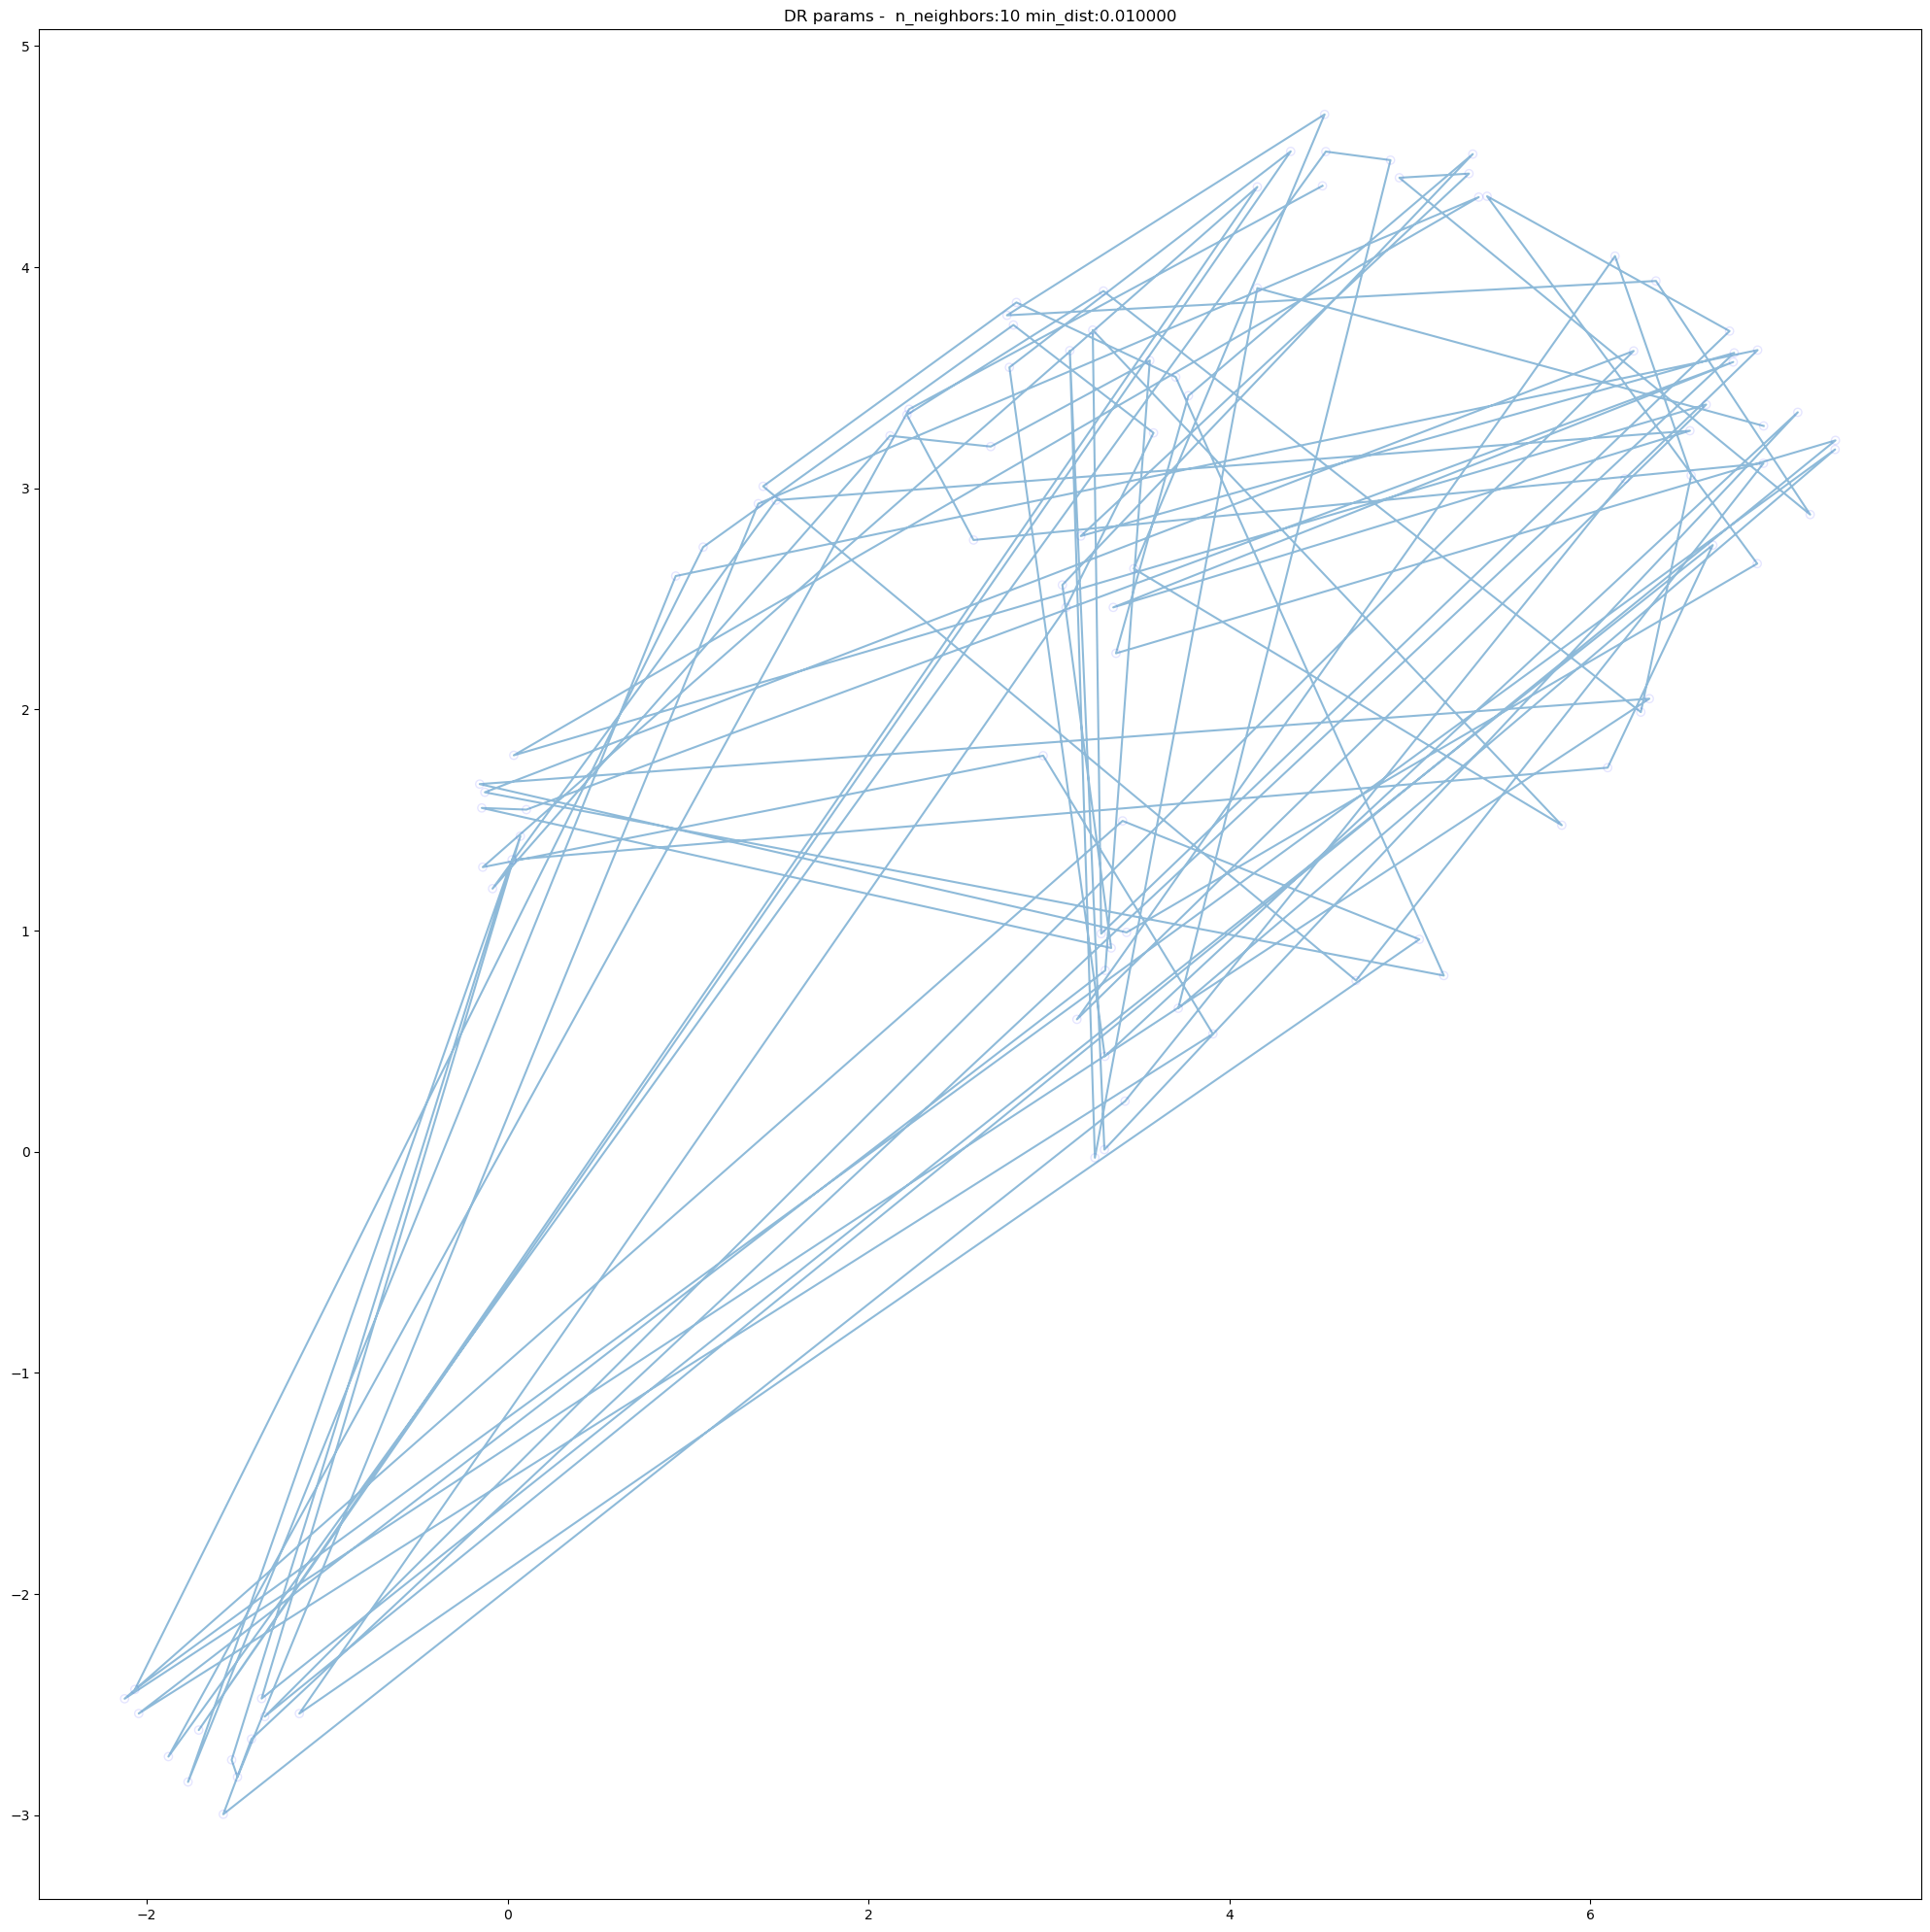

In [26]:
prjs_plt = plot_projections(prjs, umap_params)

[ 3  4  2  0  1 -1]


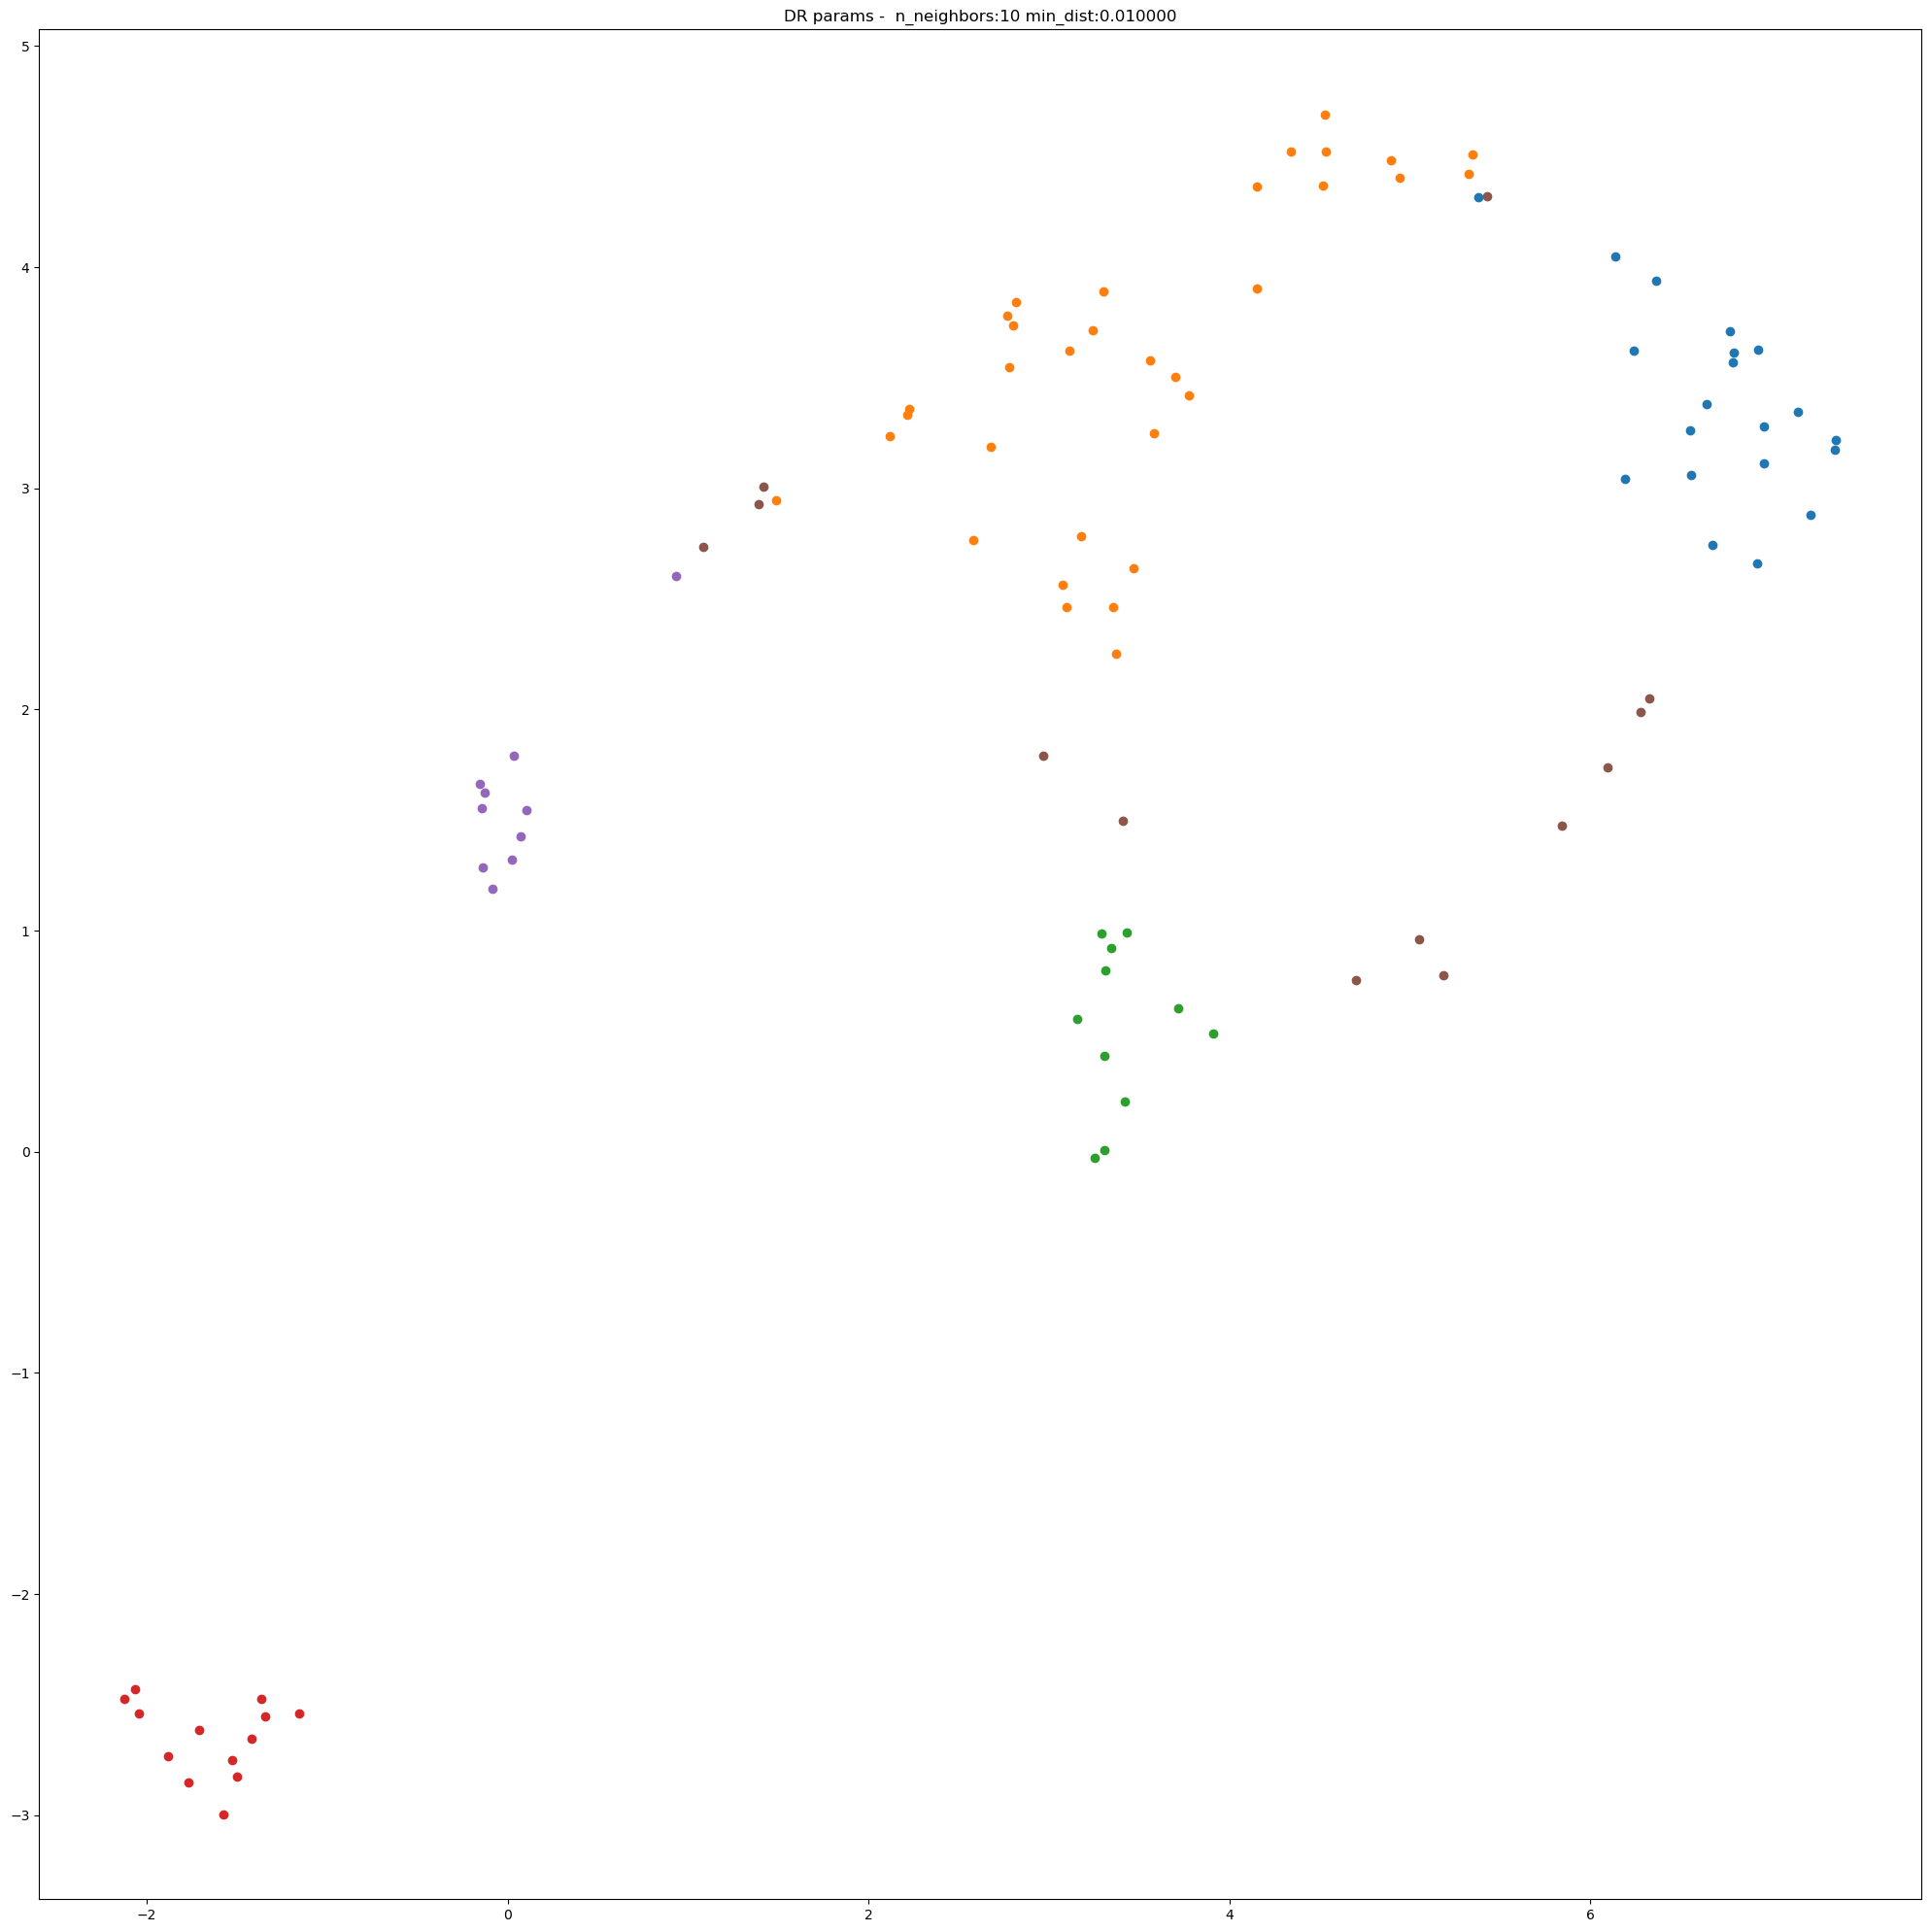

In [27]:
prjs_plt = plot_projections_clusters(prjs, clusters_labels, umap_params)

Intentando toy

In [38]:
#| export
verbose                       = 1  
show_plots                    = False
reset_kernel                  = False
pre_configured_case           = True 
case_id                       = 7 
frequency_factor              = 1
frequency_factor_change_alias = True 
cuda_device                   = 0

In [39]:
#| export
import pandas as pd
import numpy as np
from fastcore.all import *
import wandb
from dvats.load import TSArtifact, infer_or_inject_freq
import pickle
import matplotlib
import matplotlib.pyplot as plt
from tsai.data.external import convert_tsf_to_dataframe
from tsai.utils import stack_pad

In [40]:
base_path = Path.home()

In [41]:
import dvats.config as cfg_

In [42]:
#| export
config = cfg_.get_artifact_config_sd2a(verbose = 0)
if pre_configured_case: 
    print(f"Pre configured case id: {case_id}")
    cfg_.force_artifact_config_sd2a(
        config = config, 
        id = case_id, 
        verbose = verbose, 
        both = verbose > 0, 
        frequency_factor = frequency_factor, 
        frequency_factor_change_alias = frequency_factor_change_alias
    )
cfg_.show_attrdict(config)

Pre configured case id: 7
Selecting  stumpy_toy_0
resampling_freq: None
wandb_artifacts_path: ./data/wandb_artifacts
missing_values_technique: None
date_offset: None
date_format: %Y-%m-%d %H:%M:%S
joining_train_test: False
data_cols: [0] -> []
data_fpath: ~/data/PulsusParadoxusSP02_30_10000.csv -> ~/data/toy.csv
missing_values_constant: None
range_testing: None
freq: 1s
csv_config: {'header': None} -> {}
start_date: None
normalize_training: False
time_col: None
artifact_name: PulsusParadoxus-SP02 -> toy
use_wandb: True
test_split: None
range_training: None
artifact_name: toy
csv_config: {}
data_cols: []
data_fpath: ~/data/toy.csv
date_format: %Y-%m-%d %H:%M:%S
date_offset: None
freq: 1s
joining_train_test: False
missing_values_technique: None
missing_values_constant: None
normalize_training: False
range_training: None
range_testing: None
resampling_freq: None
start_date: None
test_split: None
time_col: None
use_wandb: True
wandb_artifacts_path: ./data/wandb_artifacts


In [43]:
#| export
ext = str(config.data_fpath).split('.')[-1]

if ext == 'pickle':
    df = pd.read_pickle(config.data_fpath)
    
elif ext in ['csv','txt']:
    df = pd.read_csv(config.data_fpath, **config.csv_config)
    
elif ext == 'tsf':
    data, _, _, _, _ = convert_tsf_to_dataframe(os.path.expanduser(config.data_fpath))
    config.update({'start_date': data.start_timestamp[0]}, allow_val_change=True)
    date_format = config.date_format
    df = pd.DataFrame(stack_pad(data.series_value).T)
    
else:
    raise Exception('The data file path has an unsupported extension')

In [44]:
#| export
if config.time_col is not None:
    if verbose > 0: print("time_col: "+str(config.time_col))
    
    if isinstance(config.time_col, int): 
        if verbose > 0: print("Op 1: time_col int")
        datetime = df.iloc[:, config.time_col]
    
    elif isinstance(config.time_col, list): 
        if verbose > 0: print("Op 2: time_col list")
        datetime = df.iloc[:, config.time_col].apply(lambda x: x.astype(str).str.cat(sep='-'), axis=1)
    
    index = pd.DatetimeIndex(datetime)
    
    if config.date_offset:
        index += config.date_offset
    
    df = df.set_index(index, drop=False)   
    
    #Delete Timestamp col
    col_name = df.columns[config.time_col]
    
    if verbose > 0: print("... drop Timestamp col " + str(col_name))
    
    df = df.drop(col_name, axis=1)
    
if verbose > 0: display(df.head())

,T3,T2,T1
0,0.741822,0.637180,0.565117
1,0.739731,0.629415,0.493513
2,0.718757,0.539220,0.469350
3,0.730169,0.577670,0.444100
4,0.752406,0.570180,0.373008


In [45]:
#| export
df = infer_or_inject_freq(
    df, 
    injected_freq=config.freq, 
    start_date=config.start_date, 
    format=config.date_format
)
if verbose > 0: print(df.index.freq)

<Second>


In [46]:
#| export
# Subset of variables
if config.data_cols:
    if verbose > 0: print("data_cols: ", config.data_cols)
    df = df.iloc[:, config.data_cols]

if verbose > 0: print(f'Num. variables: {len(df.columns)}')

Num. variables: 3


In [47]:
#| export
rg = config.range_training

if isinstance(rg, list):
    rg_training = rg
    
elif isinstance(rg, dict):
    rg_training = pd.date_range(rg['start'], rg['end'], freq=rg['freq'])
    
elif config.test_split:
    rg_training = df.index[:math.ceil(len(df) * (1-config.test_split))]

else:
    rg_training = None
    
df_training = df[df.index.isin(rg_training)] if rg_training is not None else df

In [48]:
#| export
# Testing data
rg = config.range_testing

if rg or config.test_split:
    
    if isinstance(rg, list):
        rg_testing = rg

    elif isinstance(rg, dict):
        rg_testing = pd.date_range(rg['start'], rg['end'], freq=rg['freq'])

    elif config.test_split:
        rg_testing = df.index[math.ceil(len(df) * (1 - config.test_split)):]

    else:
        rg_testing = None
    
    df_testing = df[df.index.isin(rg_testing)]
    testing_artifact = TSArtifact.from_df(df_testing,
                                          name=config.artifact_name, 
                                          missing_values_technique=config.missing_values_technique,
                                          resampling_freq=config.resampling_freq, 
                                          normalize=False,
                                          path=str(Path.home()/config.wandb_artifacts_path))
    display(testing_artifact.metadata)
    if df_testing.index.duplicated().any():
        print("There exist duplicated value(s) in the index dataframe.")
    else:
        if verbose > 0: print("There is no duplicated value in the index dataframe.")
else:
    if verbose > 0: print("rg "+ str(rg) + " | test_split "+ str(config.test_split))
    testing_artifact = None

rg None | test_split None


In [49]:
df.shape

(550, 3)

In [51]:
30*550/100

165.0

In [52]:
550-165

385